In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


In [2]:
# Uploading the Dataset
df=pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
df.head(2)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


## Importing Libraries

In [3]:
# Preprocessing & modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingClassifier,VotingClassifier

# Models used for comparison
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

import joblib




## Studying Dataset basics

In [4]:
df.shape


(5110, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## Exploratory Data Analysis

#### Checking for numerical data

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'avg_glucose_level'}>],
       [<Axes: title={'center': 'bmi'}>, <Axes: >]], dtype=object)

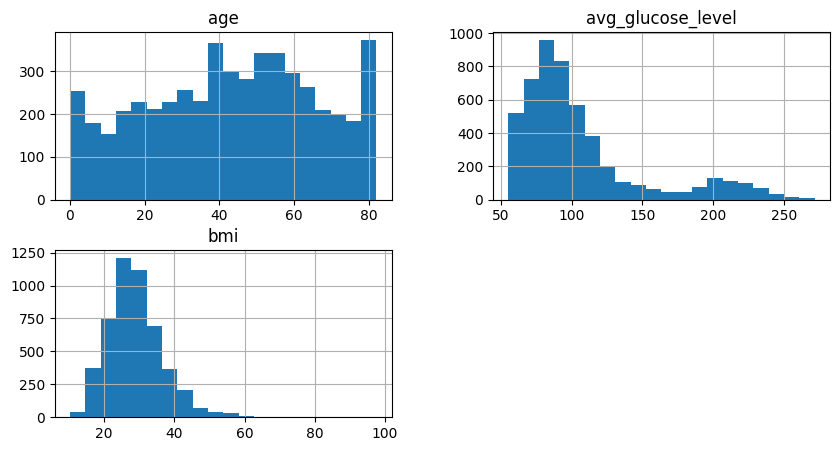

In [7]:
numeric_features=['age','avg_glucose_level','bmi']
df[numeric_features].hist(bins=20,figsize=(10,5))

#### Checking for Categorical Data

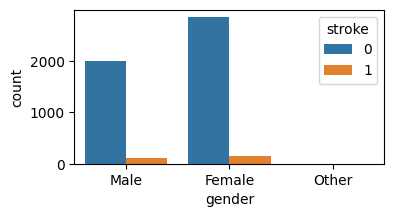

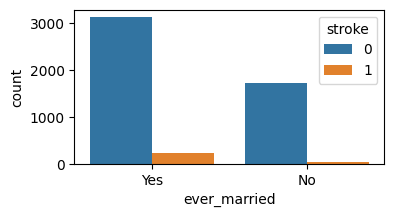

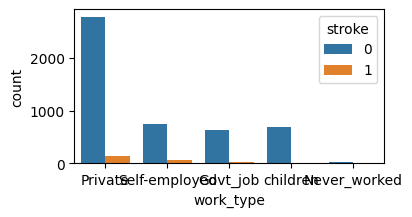

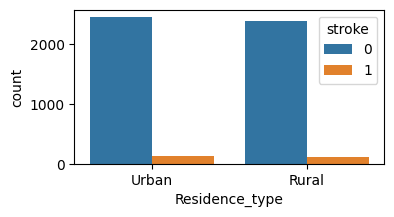

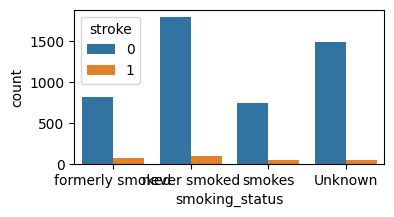

In [9]:
categorical_features = ['gender','ever_married','work_type','Residence_type','smoking_status']
for col in categorical_features:
    plt.figure(figsize=(4, 2))
    sns.countplot(x=col, hue='stroke', data=df)
    plt.show()


## Data cleaning

#### Missing value imputation

In [10]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Here only *BMI* has missing values.Hence filling BMI with median.

In [13]:
from sklearn.tree import DecisionTreeRegressor

In [14]:
DT_bmi_pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('lr', DecisionTreeRegressor(random_state=42))
])
X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)
Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X, Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]), index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi


/tmp/ipykernel_47/3384925914.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)


#### Checking and removing duplicates(if any)

In [15]:
duplicates = df[df.duplicated()]
if duplicates.empty:
    print("No duplicate rows found.Hence no need to remove any Rows.")
else:
    print("Duplicate rows found:")
    print(duplicates)


No duplicate rows found.Hence no need to remove any Rows.


#### Drop unnecessary columns

In [16]:
df.drop('id',axis=1,inplace=True)



In [17]:
df.head(2)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.879487,never smoked,1


## Feature Engineering

#### Encoding Categorical variables

In [19]:
numeric_features = ['age', 'avg_glucose_level', 'bmi']
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [20]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [21]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

## Train-Test Split

In [54]:
X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



In [55]:
X_train.head(2)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
845,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked
3744,Male,15.0,0,0,No,Private,Rural,122.25,21.0,never smoked


## Building different models on given Dataset

#### 1.Logistic regression :-

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

In [60]:
logreg_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train
logreg_pipe.fit(X_train, y_train)

# Predict
y_pred = logreg_pipe.predict(X_test)
y_prob = logreg_pipe.predict_proba(X_test)[:, 1]

# Metrics
print("===== Logistic Regression (Library) =====")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

===== Logistic Regression (Library) =====
Accuracy: 0.9510763209393346
ROC-AUC: 0.8416255144032921

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022


Confusion Matrix:
 [[972   0]
 [ 50   0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
class LogisticRegressionScratch:
    def __init__(self, lr=0.01, epochs=5000):
        self.lr = lr
        self.epochs = epochs
        self.weights = None
        self.bias = None
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y).reshape(-1,1)
        n_samples, n_features = X.shape
        
        self.weights = np.zeros((n_features,1))
        self.bias = 0
        
        for _ in range(self.epochs):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)
            
            dw = (1/n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1/n_samples) * np.sum(y_predicted - y)
            
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
    
    def predict_prob(self, X):
        X = np.array(X)
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)
    
    def predict(self, X, threshold=0.5):
        return (self.predict_prob(X) >= threshold).astype(int)

# Preprocess to NumPy arrays
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

scratch_logreg = LogisticRegressionScratch(lr=0.01, epochs=5000)
scratch_logreg.fit(X_train_scaled, y_train)

y_pred_scratch = scratch_logreg.predict(X_test_scaled)
y_prob_scratch = scratch_logreg.predict_prob(X_test_scaled)

print("===== Logistic Regression (Scratch) =====")
print("Accuracy:", accuracy_score(y_test, y_pred_scratch))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_scratch))
print("\nClassification Report:\n", classification_report(y_test, y_pred_scratch))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_scratch))

===== Logistic Regression (Scratch) =====
Accuracy: 0.9510763209393346
ROC-AUC: 0.8076131687242799

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022


Confusion Matrix:
 [[972   0]
 [ 50   0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### *Try Regularization for logisctic regression*

#### 2.Random Forest :-

In [63]:
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', RandomForestClassifier(n_estimators=200, class_weight='balanced'))])
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022



In [65]:
class RandomForestScratch:
    def __init__(self, n_estimators=10, max_depth=None, max_features='sqrt', random_state=42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []
        self.random_state = random_state
        np.random.seed(random_state)
    
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples = X.shape[0]
        self.trees = []
        
        for _ in range(self.n_estimators):
            # Bootstrap sample
            idxs = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[idxs]
            y_sample = y[idxs]
            
            # Build tree
            tree = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, random_state=self.random_state)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
    
    def predict(self, X):
        X = np.array(X)
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # Majority vote
        return np.squeeze(np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=tree_preds))
    
    def predict_proba(self, X):
        X = np.array(X)
        tree_probs = np.array([tree.predict_proba(X) for tree in self.trees])
        # Average probabilities
        return np.mean(tree_probs, axis=0)



In [67]:
from sklearn.tree import DecisionTreeClassifier


In [68]:
# Preprocess
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# Train scratch RF
scratch_rf = RandomForestScratch(n_estimators=50, max_depth=5)
scratch_rf.fit(X_train_scaled, y_train)

# Predict
y_pred_scratch_rf = scratch_rf.predict(X_test_scaled)
y_prob_scratch_rf = scratch_rf.predict_proba(X_test_scaled)[:,1]

# Metrics
print("Accuracy (Scratch RF):", accuracy_score(y_test, y_pred_scratch_rf))
print("ROC-AUC (Scratch RF):", roc_auc_score(y_test, y_prob_scratch_rf))
print("\nClassification Report (Scratch RF):\n", classification_report(y_test, y_pred_scratch_rf))
print("\nConfusion Matrix (Scratch RF):\n", confusion_matrix(y_test, y_pred_scratch_rf))


Accuracy (Scratch RF): 0.9510763209393346
ROC-AUC (Scratch RF): 0.8320370370370371

Classification Report (Scratch RF):
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022


Confusion Matrix (Scratch RF):
 [[972   0]
 [ 50   0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### XGBoost:-

In [71]:
from xgboost import XGBClassifier

# XGBoost using library
xgb_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

# Train
xgb_pipe.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_pipe.predict(X_test)
y_prob_xgb = xgb_pipe.predict_proba(X_test)[:,1]

# Metrics
print("Accuracy (XGBoost Library):", accuracy_score(y_test, y_pred_xgb))
print("ROC-AUC (XGBoost Library):", roc_auc_score(y_test, y_prob_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


Accuracy (XGBoost Library): 0.9510763209393346
ROC-AUC (XGBoost Library): 0.8419855967078189

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022


Confusion Matrix:
 [[972   0]
 [ 50   0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
from sklearn.tree import DecisionTreeRegressor

class XGBoostScratch:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.tree_weights = []

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y).reshape(-1,1)
        # Initialize predictions
        y_pred = np.full(y.shape, 0.5)
        
        for _ in range(self.n_estimators):
            # Compute gradient
            grad = y_pred - y  # derivative of logloss wrt prediction
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, grad)
            update = tree.predict(X).reshape(-1,1)
            y_pred -= self.learning_rate * update
            self.trees.append(tree)

    def predict_prob(self, X):
        X = np.array(X)
        y_pred = np.full((X.shape[0],1), 0.5)
        for tree in self.trees:
            update = tree.predict(X).reshape(-1,1)
            y_pred -= self.learning_rate * update
        return self.sigmoid(y_pred)

    def predict(self, X, threshold=0.5):
        return (self.predict_prob(X) >= threshold).astype(int)


In [73]:
# Preprocess data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# Train scratch XGBoost
scratch_xgb = XGBoostScratch(n_estimators=50, learning_rate=0.1, max_depth=3)
scratch_xgb.fit(X_train_scaled, y_train)

# Predict
y_pred_scratch_xgb = scratch_xgb.predict(X_test_scaled)
y_prob_scratch_xgb = scratch_xgb.predict_prob(X_test_scaled)

# Metrics
print("Accuracy (Scratch XGBoost):", accuracy_score(y_test, y_pred_scratch_xgb))
print("ROC-AUC (Scratch XGBoost):", roc_auc_score(y_test, y_prob_scratch_xgb))
print("\nClassification Report (Scratch XGBoost):\n", classification_report(y_test, y_pred_scratch_xgb))
print("\nConfusion Matrix (Scratch XGBoost):\n", confusion_matrix(y_test, y_pred_scratch_xgb))


Accuracy (Scratch XGBoost): 0.06262230919765166
ROC-AUC (Scratch XGBoost): 0.8386831275720165

Classification Report (Scratch XGBoost):
               precision    recall  f1-score   support

           0       1.00      0.01      0.03       972
           1       0.05      1.00      0.09        50

    accuracy                           0.06      1022
   macro avg       0.52      0.51      0.06      1022
weighted avg       0.95      0.06      0.03      1022


Confusion Matrix (Scratch XGBoost):
 [[ 14 958]
 [  0  50]]


## Evaluation

In [75]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, xgb_pipe.predict_proba(X_test)[:,1])


0.8419855967078189

## Model interpretability using SHAP:-

In [77]:
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

numerical_features, categorical_features


(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'],
 ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

In [78]:
# extract features again
numerical_features = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object','category']).columns.tolist()

# numerical features remain same
num_features = numerical_features

# K get OneHotEncoder from the 'cat' transformer inside pipeline
ohe = pipe_rf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']

# get encoded feature names
ohe_features = ohe.get_feature_names_out(categorical_features)

# combine
all_features = num_features + list(ohe_features)


In [80]:
X_test_trans = pipe_rf.named_steps['preprocessor'].transform(X_test)

try:
    X_test_trans = X_test_trans.toarray()   # SHAP sometimes needs dense
except:
    pass


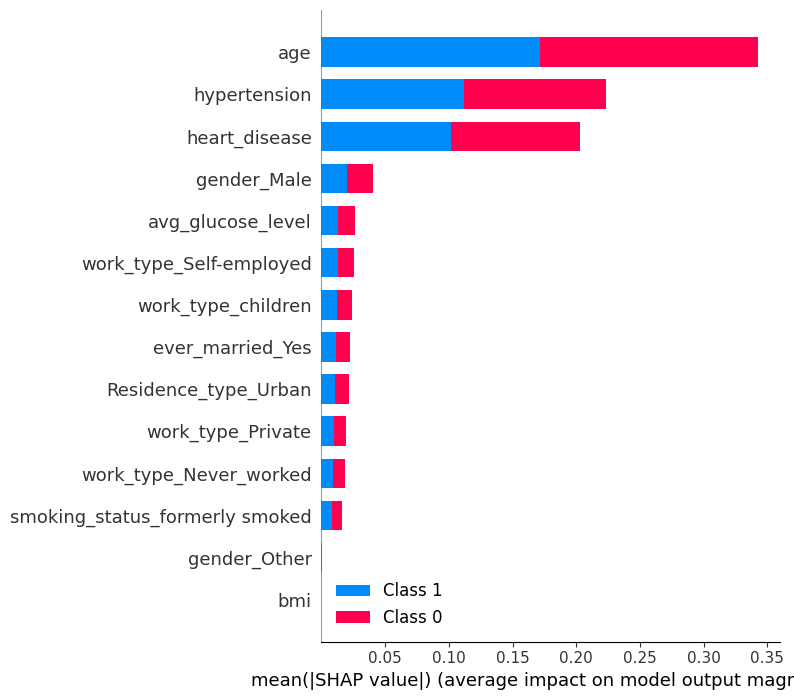

In [81]:
import shap

explainer = shap.TreeExplainer(pipe_rf.named_steps['classifier'])
shap_values = explainer.shap_values(X_test_trans)

shap.summary_plot(shap_values, X_test_trans, feature_names=all_features)


In [83]:
feature_names = pipe_rf.named_steps['preprocessor'].get_feature_names_out()


In [84]:
shap.initjs()

shap.force_plot(
    explainer.expected_value[1],
    shap_values[1][0],      # first test sample
    feature_names=feature_names
)


## Hyperparameter tuning using GridSearchCV and RandomSearchCV

In [87]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# Random Forest parameter grid
rf_param_dist = {
    'classifier__n_estimators': [100, 200, 400, 800],
    'classifier__max_depth': [None, 5, 10, 20],
    'classifier__min_samples_split': [2, 4, 8],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': ['balanced']
}

# XGBoost parameter grid
xgb_param_dist = {
    'classifier__n_estimators': [50, 100, 200, 400],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0],
}

# compute scale_pos_weight for XGBoost
ratio = (y_train == 0).sum() / (y_train == 1).sum()
xgb_param_dist['classifier__scale_pos_weight'] = [ratio, max(1, int(ratio/2)), max(1, int(ratio*2))]

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized search for Random Forest
rand_rf = RandomizedSearchCV(
    pipe_rf,            # updated pipeline variable
    rf_param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
rand_rf.fit(X_train, y_train)
print("Best RF params:", rand_rf.best_params_)
print("Best RF ROC-AUC:", rand_rf.best_score_)

# Randomized search for XGBoost
rand_xgb = RandomizedSearchCV(
    xgb_pipe,           # updated pipeline variable
    xgb_param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
rand_xgb.fit(X_train, y_train)
print("Best XGB params:", rand_xgb.best_params_)
print("Best XGB ROC-AUC:", rand_xgb.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categ

[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   1.0s
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   0.9s
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_split=4, classifier__n_estimators=800; total time=   3.8s
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=400; total time=   1.7s
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.9s
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifi

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   0.9s
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_split=4, classifier__n_estimators=800; total time=   3.8s
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_split=4, classifier__n_estimators=800; total time=   3.6s
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.9s
[CV] END classifier__class_weight=balanced, classifier__max_depth=5, classifier__min_samples_leaf=2, classifier__min_samples_split=8, classifier__n_estimators=100; total time=   0.4s
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, class

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   0.9s
[CV] END classifier__class_weight=balanced, classifier__max_depth=None, classifier__min_samples_leaf=2, classifier__min_samples_split=4, classifier__n_estimators=800; total time=   3.8s
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=400; total time=   1.7s
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=8, classifier__n_estimators=400; total time=   1.7s
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.9s
[CV] END classifier__class_weight=balanced, classifier__max_depth=5, classifie

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Best RF params: {'classifier__n_estimators': 400, 'classifier__min_samples_split': 4, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 5, 'classifier__class_weight': 'balanced'}
Best RF ROC-AUC: 0.8250402486938476
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categ

Best XGB params: {'classifier__subsample': 1.0, 'classifier__scale_pos_weight': 19.542713567839197, 'classifier__n_estimators': 400, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}
Best XGB ROC-AUC: 0.8385475098039364


In [88]:
print("Best RF params:", rand_rf.best_params_)
print("Best RF ROC-AUC:", rand_rf.best_score_)

print("Best XGB params:", rand_xgb.best_params_)
print("Best XGB ROC-AUC:", rand_xgb.best_score_)

Best RF params: {'classifier__n_estimators': 400, 'classifier__min_samples_split': 4, 'classifier__min_samples_leaf': 4, 'classifier__max_depth': 5, 'classifier__class_weight': 'balanced'}
Best RF ROC-AUC: 0.8250402486938476
Best XGB params: {'classifier__subsample': 1.0, 'classifier__scale_pos_weight': 19.542713567839197, 'classifier__n_estimators': 400, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.01}
Best XGB ROC-AUC: 0.8385475098039364


## Cross validation

In [89]:
best_rf = rand_rf.best_estimator_
best_xgb = rand_xgb.best_estimator_
best_lr = pipe_lr  # you can tune LR similarly

for name, model in [('Logistic', best_lr), ('RandomForest', best_rf), ('XGBoost', best_xgb)]:
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    print(f"{name} CV ROC-AUC: mean={scores.mean():.4f}, std={scores.std():.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Logistic CV ROC-AUC: mean=0.8372, std=0.0095


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


RandomForest CV ROC-AUC: mean=0.8223, std=0.0131


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


XGBoost CV ROC-AUC: mean=0.8385, std=0.0114


In [90]:
# To get predictions for ROC curve aggregated across folds
oof_preds_rf = cross_val_predict(best_rf, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:,1]
print("OOF RF ROC-AUC:", roc_auc_score(y_train, oof_preds_rf))


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


OOF RF ROC-AUC: 0.8206764085275956


## Ensemble methods:-

#### 1.Voting:-

In [91]:
# Helper to extract classifier whether model is Pipeline or not
def get_clf(model):
    if hasattr(model, "named_steps"):
        return model.named_steps["classifier"]
    return model

# Build Voting Classifier safely
voting = VotingClassifier(
    estimators=[
        ('lr', get_clf(best_lr)),
        ('rf', get_clf(best_rf)),
        ('xgb', get_clf(best_xgb))
    ],
    voting='soft',
    weights=[1, 2, 3]   # adjust if needed
)

# Combine with preprocessor
from sklearn.pipeline import make_pipeline

stacked_pipe = make_pipeline(preprocessor, voting)

# Train
stacked_pipe.fit(X_train, y_train)

# Evaluate
proba = stacked_pipe.predict_proba(X_test)[:, 1]
print("Voting ROC-AUC:", roc_auc_score(y_test, proba))



Voting ROC-AUC: 0.8475720164609054


In [100]:
voting_proba = stacked_pipe.predict_proba(X_test)[:, 1]
voting_pred = stacked_pipe.predict(X_test)

voting_results = {
    'Accuracy': accuracy_score(y_test, voting_pred),
    'ROC-AUC': roc_auc_score(y_test, voting_proba)
}

print("=== Voting Classifier Results ===")
print("Accuracy:", voting_results['Accuracy'])
print("ROC-AUC:", voting_results['ROC-AUC'])
print("\nClassification Report:\n", classification_report(y_test, voting_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, voting_pred))

=== Voting Classifier Results ===
Accuracy: 0.7172211350293543
ROC-AUC: 0.8475720164609054

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.71      0.83       972
           1       0.13      0.84      0.23        50

    accuracy                           0.72      1022
   macro avg       0.56      0.78      0.53      1022
weighted avg       0.95      0.72      0.80      1022


Confusion Matrix:
 [[691 281]
 [  8  42]]


#### 2.Stacking:-

In [102]:
num_features = ['age', 'avg_glucose_level', 'bmi']

cat_features = [
    'gender',
    'hypertension',
    'heart_disease',
    'ever_married',
    'work_type',
    'Residence_type',
    'smoking_status'
]


In [103]:


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ]
)


In [104]:


best_lr = LogisticRegression(max_iter=300)
best_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
best_xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)


In [105]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('lr', best_lr)
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=300),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

stack_pipe = Pipeline([
    ('prep', preprocessor),
    ('model', stack_model)
])


In [107]:
stacking_proba = stack_pipe.predict_proba(X_test)[:, 1]
stacking_pred = stack_pipe.predict(X_test)

stacking_results = {
    'Accuracy': accuracy_score(y_test, stacking_pred),
    'ROC-AUC': roc_auc_score(y_test, stacking_proba)
}

print("=== Stacking Classifier Results ===")
print("Accuracy:", stacking_results['Accuracy'])
print("ROC-AUC:", stacking_results['ROC-AUC'])
print("\nClassification Report:\n", classification_report(y_test, stacking_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, stacking_pred))


=== Stacking Classifier Results ===
Accuracy: 0.9500978473581213
ROC-AUC: 0.8391975308641975

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.33      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.64      0.51      0.51      1022
weighted avg       0.92      0.95      0.93      1022


Confusion Matrix:
 [[970   2]
 [ 49   1]]


In [108]:
stack_pipe.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender', 'hypertension',
                                                   'heart_disease',
                                                   'ever_married', 'work_type',
                                                   'Residence_type',
                                                   'smoking_status'])])),
                ('model',
                 StackingClassifier(cv=5,
                                    estimators=[('rf',
                                                 RandomFores...
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=5,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=300,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=42, ...)),
                                                ('lr',
                                                 LogisticRegression(max_iter=300))],
                                    final_estimator=LogisticRegression(max_iter=300),
                                    n_jobs=-1))])

In [116]:
comparison_df = pd.DataFrame([voting_results, stacking_results], index=['Voting', 'Stacking'])
print(" Comparison of Voting vs Stacking ")
print(comparison_df)

better_model = 'Voting' if voting_results['ROC-AUC'] > stacking_results['ROC-AUC'] else 'Stacking'
print(f"\nBased on ROC-AUC, the better ensemble is: {better_model}")

 Comparison of Voting vs Stacking 
          Accuracy   ROC-AUC
Voting    0.717221  0.847572
Stacking  0.950098  0.839198

Based on ROC-AUC, the better ensemble is: Voting


In [110]:
#Evaluating stacking models
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

y_pred = stack_pipe.predict(X_test)
y_proba = stack_pipe.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


ROC-AUC: 0.8391975308641975

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.33      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.64      0.51      0.51      1022
weighted avg       0.92      0.95      0.93      1022


Confusion Matrix:
 [[970   2]
 [ 49   1]]


## Plot ROC Curve:-

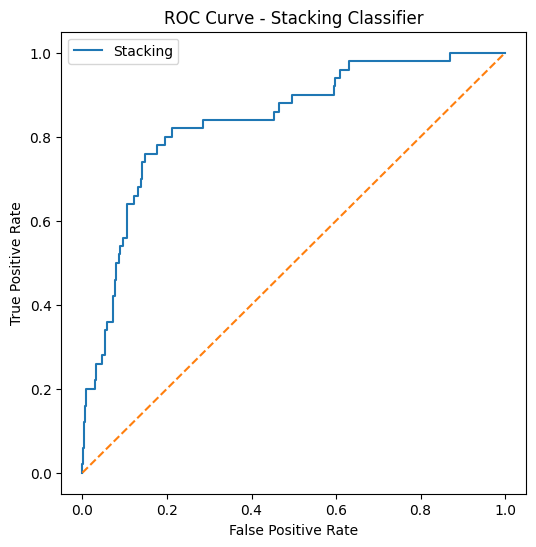

In [98]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label="Stacking")
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Stacking Classifier")
plt.legend()
plt.show()


## Feature importance visualisation(tree based)

In [114]:
import numpy as np
import pandas as pd


numeric_features = ['age', 'avg_glucose_level', 'bmi']


categorical_features = ['gender','ever_married','work_type','Residence_type','smoking_status']


num_features = numeric_features


cat_transformer = preprocessor.named_transformers_['cat']


if hasattr(cat_transformer, 'named_steps'):
    ohe = cat_transformer.named_steps['onehot']
else:
    ohe = cat_transformer

cat_features_ohe = ohe.get_feature_names_out() 


all_features = np.concatenate([num_features, cat_features_ohe])

print("All feature names after preprocessing:", all_features)


All feature names after preprocessing: ['age' 'avg_glucose_level' 'bmi' 'gender_Female' 'gender_Male'
 'gender_Other' 'hypertension_0' 'hypertension_1' 'heart_disease_0'
 'heart_disease_1' 'ever_married_No' 'ever_married_Yes'
 'work_type_Govt_job' 'work_type_Never_worked' 'work_type_Private'
 'work_type_Self-employed' 'work_type_children' 'Residence_type_Rural'
 'Residence_type_Urban' 'smoking_status_Unknown'
 'smoking_status_formerly smoked' 'smoking_status_never smoked'
 'smoking_status_smokes']


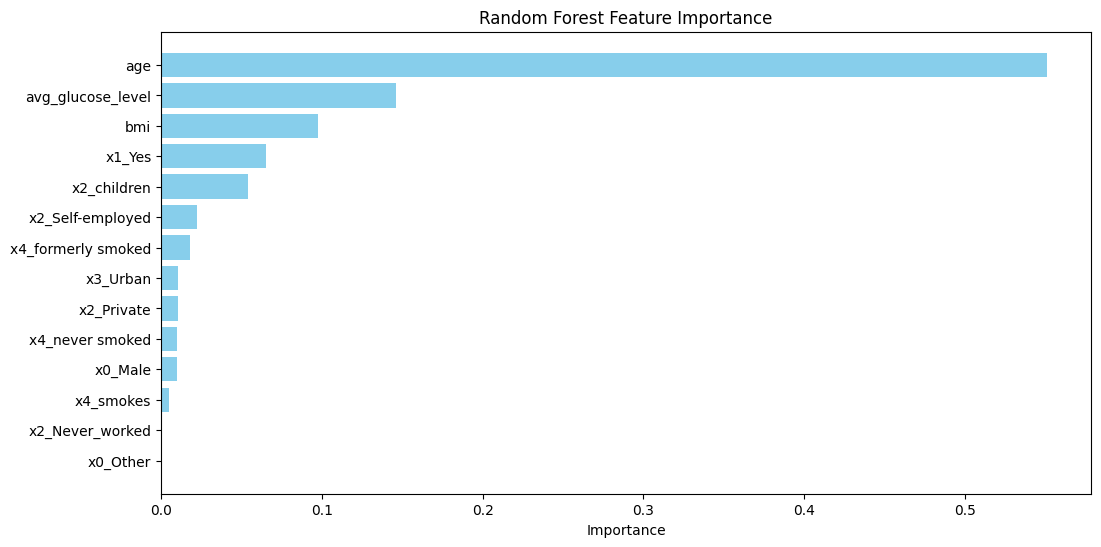

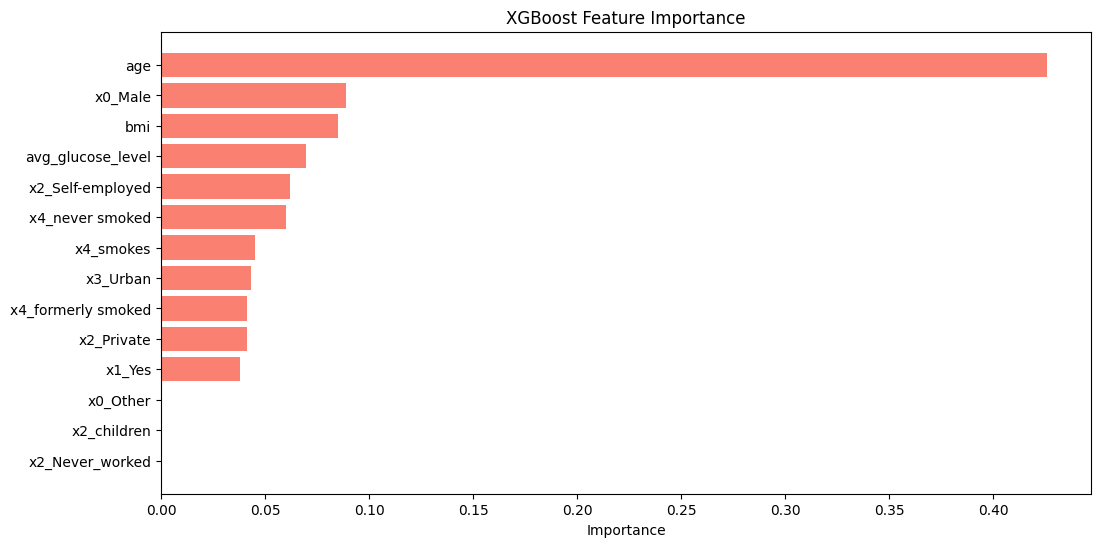

In [121]:
rf_model = rand_rf.best_estimator_.named_steps['classifier']
xgb_model = rand_xgb.best_estimator_.named_steps['classifier']


numeric_features = ['age', 'avg_glucose_level', 'bmi']
cat_transformer = rand_rf.best_estimator_.named_steps['preprocessor'].named_transformers_['cat']
ohe = cat_transformer.named_steps['onehot'] if hasattr(cat_transformer, 'named_steps') else cat_transformer
cat_features_ohe = ohe.get_feature_names_out()
all_features = np.concatenate([numeric_features, cat_features_ohe])


rf_importances = rf_model.feature_importances_
rf_df = pd.DataFrame({'feature': all_features, 'importance': rf_importances}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
plt.barh(rf_df['feature'], rf_df['importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.show()


xgb_importances = xgb_model.feature_importances_
xgb_df = pd.DataFrame({'feature': all_features, 'importance': xgb_importances}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
plt.barh(xgb_df['feature'], xgb_df['importance'], color='salmon')
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.show()

In [122]:
# Random Forest numeric table
print("Random Forest Feature Importance (Top 10):")
print(rf_df.head(10))

# XGBoost numeric table
print("\nXGBoost Feature Importance (Top 10):")
print(xgb_df.head(10))


Random Forest Feature Importance (Top 10):
               feature  importance
0                  age    0.551040
1    avg_glucose_level    0.146092
2                  bmi    0.097348
5               x1_Yes    0.065459
9          x2_children    0.054189
8     x2_Self-employed    0.022290
11  x4_formerly smoked    0.018156
10            x3_Urban    0.010378
7           x2_Private    0.010348
12     x4_never smoked    0.009657

XGBoost Feature Importance (Top 10):
               feature  importance
0                  age    0.425851
3              x0_Male    0.088769
2                  bmi    0.084882
1    avg_glucose_level    0.069778
8     x2_Self-employed    0.062010
12     x4_never smoked    0.060051
13           x4_smokes    0.044923
10            x3_Urban    0.043146
11  x4_formerly smoked    0.041508
7           x2_Private    0.041368


## Calibration curve/Probability reliability analysis

In [123]:
from sklearn.calibration import calibration_curve

In [124]:
# Helpper function to plot calibration curve
def plot_calibration_curve(y_true, y_probs, model_name):

    prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)
    
    plt.plot(prob_pred, prob_true, marker='o', label=model_name)
    plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Perfectly calibrated')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration Curve / Probability Reliability')
    plt.legend()


In [126]:
# prepare predicted probabilities for each model

# Logistic Regression
lr_probs = logreg_pipe.predict_proba(X_test)[:,1]

# Random Forest
rf_probs = pipe_rf.predict_proba(X_test)[:,1]

# XGBoost
xgb_probs = xgb_pipe.predict_proba(X_test)[:,1]

# Voting
voting_probs = stacked_pipe.predict_proba(X_test)[:,1]

# Stacking
stacking_probs = stack_pipe.predict_proba(X_test)[:,1]


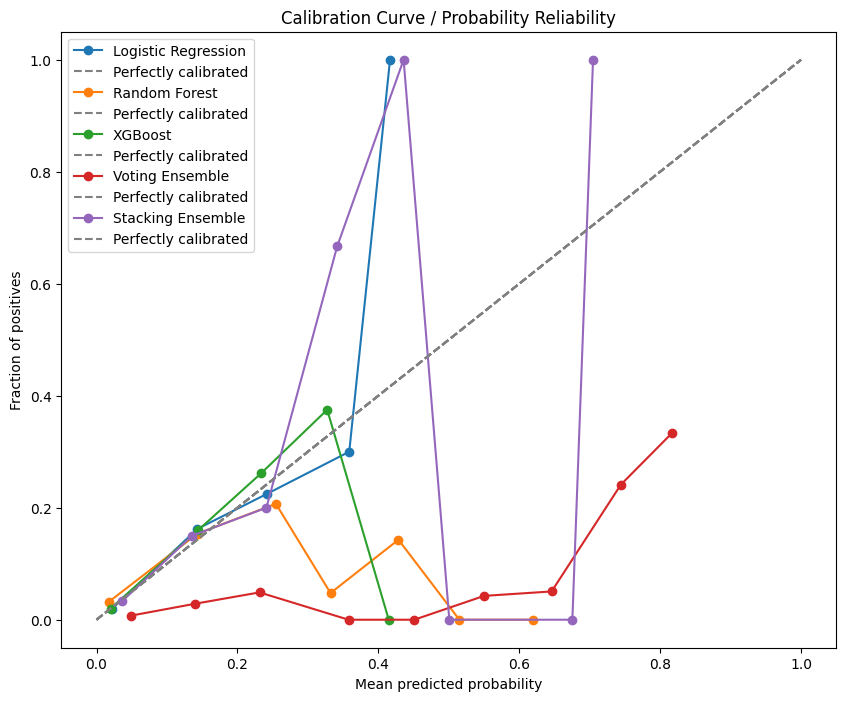

In [128]:
# plot curve

plt.figure(figsize=(10,8))

plot_calibration_curve(y_test, lr_probs, "Logistic Regression")
plot_calibration_curve(y_test, rf_probs, "Random Forest")
plot_calibration_curve(y_test, xgb_probs, "XGBoost")
plot_calibration_curve(y_test, voting_probs, "Voting Ensemble")
plot_calibration_curve(y_test, stacking_probs, "Stacking Ensemble")

plt.show()


In [129]:
# Brier score
from sklearn.metrics import brier_score_loss

models = {
    "Logistic Regression": lr_probs,
    "Random Forest": rf_probs,
    "XGBoost": xgb_probs,
    "Voting Ensemble": voting_probs,
    "Stacking Ensemble": stacking_probs
}

for name, probs in models.items():
    score = brier_score_loss(y_test, probs)
    print(f"Brier Score ({name}): {score:.4f}")


Brier Score (Logistic Regression): 0.0408
Brier Score (Random Forest): 0.0468
Brier Score (XGBoost): 0.0419
Brier Score (Voting Ensemble): 0.1566
Brier Score (Stacking Ensemble): 0.0417


## Misclassification analysis for stroke

In [130]:
# Helper function for stroke misclassifiaction
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

def misclassification_analysis(y_true, y_pred, model_name="Model"):
    """
    Analyzes false positives (FP) and false negatives (FN) specifically for stroke=1
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"=== {model_name} Misclassification Analysis ===")
    print("Confusion Matrix:\n", cm)
    print(f"False Negatives (stroke=1 predicted as 0): {fn}")
    print(f"False Positives (stroke=0 predicted as 1): {fp}")
    print(f"True Positives: {tp}, True Negatives: {tn}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    print("-"*50)
    
    # Optional: return as DataFrame for summary
    return pd.DataFrame({
        "Model": [model_name],
        "TP": [tp],
        "TN": [tn],
        "FP": [fp],
        "FN": [fn],
        "Recall(stroke=1)": [tp / (tp + fn) if (tp + fn) != 0 else 0],
        "Precision(stroke=1)": [tp / (tp + fp) if (tp + fp) != 0 else 0]
    })


In [136]:
# Individual model evaluation
# Logistic Regression
y_pred_lr = logreg_pipe.predict(X_test)
lr_results = misclassification_analysis(y_test, y_pred_lr, "Logistic Regression")

# Random Forest
y_pred_rf = pipe_rf.predict(X_test)
rf_results = misclassification_analysis(y_test, y_pred_rf, "Random Forest")

# XGBoost
y_pred_xgb = xgb_pipe.predict(X_test)
xgb_results = misclassification_analysis(y_test, y_pred_xgb, "XGBoost")


=== Logistic Regression Misclassification Analysis ===
Confusion Matrix:
 [[972   0]
 [ 50   0]]
False Negatives (stroke=1 predicted as 0): 50
False Positives (stroke=0 predicted as 1): 0
True Positives: 0, True Negatives: 972

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022

--------------------------------------------------
=== Random Forest Misclassification Analysis ===
Confusion Matrix:
 [[970   2]
 [ 50   0]]
False Negatives (stroke=1 predicted as 0): 50
False Positives (stroke=0 predicted as 1): 2
True Positives: 0, True Negatives: 970

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1   

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [137]:
# Ensembles evaluation
# Voting Classifier
y_pred_voting = stacked_pipe.predict(X_test)
voting_results = misclassification_analysis(y_test, y_pred_voting, "Voting Ensemble")

# Stacking Classifier
y_pred_stacking = stack_pipe.predict(X_test)
stacking_results = misclassification_analysis(y_test, y_pred_stacking, "Stacking Ensemble")


=== Voting Ensemble Misclassification Analysis ===
Confusion Matrix:
 [[691 281]
 [  8  42]]
False Negatives (stroke=1 predicted as 0): 8
False Positives (stroke=0 predicted as 1): 281
True Positives: 42, True Negatives: 691

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.71      0.83       972
           1       0.13      0.84      0.23        50

    accuracy                           0.72      1022
   macro avg       0.56      0.78      0.53      1022
weighted avg       0.95      0.72      0.80      1022

--------------------------------------------------
=== Stacking Ensemble Misclassification Analysis ===
Confusion Matrix:
 [[970   2]
 [ 49   1]]
False Negatives (stroke=1 predicted as 0): 49
False Positives (stroke=0 predicted as 1): 2
True Positives: 1, True Negatives: 970

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1 

In [139]:
# Combining all results in summary table
summary_df = pd.concat([lr_results, rf_results, xgb_results, voting_results, stacking_results], ignore_index=True)
summary_df = summary_df[["Model", "TP", "TN", "FP", "FN", "Recall(stroke=1)", "Precision(stroke=1)"]]
print("=== Summary of Misclassification Analysis ===")
print(summary_df)


=== Summary of Misclassification Analysis ===
                 Model  TP   TN   FP  FN  Recall(stroke=1)  \
0  Logistic Regression   0  972    0  50              0.00   
1        Random Forest   0  970    2  50              0.00   
2              XGBoost   0  972    0  50              0.00   
3      Voting Ensemble  42  691  281   8              0.84   
4    Stacking Ensemble   1  970    2  49              0.02   

   Precision(stroke=1)  
0             0.000000  
1             0.000000  
2             0.000000  
3             0.130031  
4             0.333333  


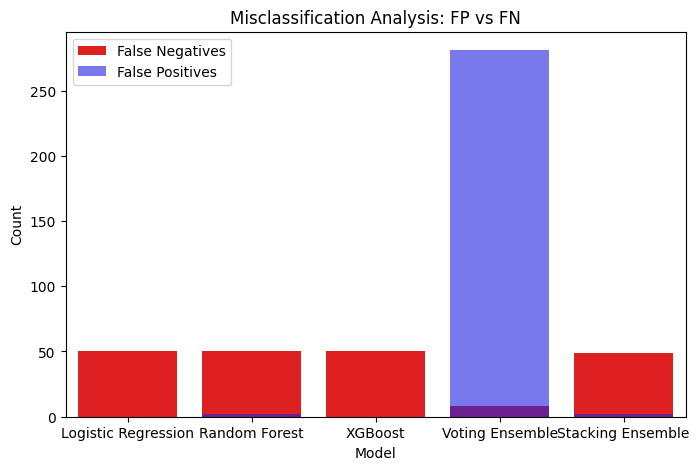

In [140]:
# False negative vs false positove evaluation
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="FN", data=summary_df, color="red", label="False Negatives")
sns.barplot(x="Model", y="FP", data=summary_df, color="blue", label="False Positives", alpha=0.6)
plt.title("Misclassification Analysis: FP vs FN")
plt.ylabel("Count")
plt.legend()
plt.show()


## Deploying pipeline and Saving(joblib)

In [99]:
import joblib
joblib.dump(stack_pipe, "stroke_stacking_model.pkl")


['stroke_stacking_model.pkl']


[CV] END classifier__class_weight=balanced, classifier__max_depth=5, classifier__min_samples_leaf=4, classifier__min_samples_split=8, classifier__n_estimators=200; total time=   0.8s
[CV] END classifier__class_weight=balanced, classifier__max_depth=20, classifier__min_samples_leaf=2, classifier__min_samples_split=4, classifier__n_estimators=200; total time=   1.0s
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.9s
[CV] END classifier__class_weight=balanced, classifier__max_depth=10, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.8s
[CV] END classifier__learning_rate=0.05, classifier__max_depth=7, classifier__n_estimators=200, classifier__scale_pos_weight=19.542713567839197, classifier__subsample=0.6; total time=   0.4s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=10, classi

In [143]:
# Logistic Regression pipeline
joblib.dump(logreg_pipe, "logistic_regression_pipeline.pkl")

# Random Forest pipeline
joblib.dump(pipe_rf, "random_forest_pipeline.pkl")

# XGBoost pipeline
joblib.dump(xgb_pipe, "xgboost_pipeline.pkl")

# Voting Ensemble
joblib.dump(stacked_pipe, "voting_ensemble_pipeline.pkl")

# Stacking Ensemble
joblib.dump(stack_pipe, "stacking_ensemble_pipeline.pkl")


['stacking_ensemble_pipeline.pkl']

In [145]:
# Suppose you have new patient data
X_new = pd.DataFrame({
    'age': [67, 45],
    'avg_glucose_level': [150, 90],
    'bmi': [28.5, 24.2],
    'gender': ['Male', 'Female'],
    'ever_married': ['Yes', 'No'],
    'work_type': ['Private', 'Self-employed'],
    'Residence_type': ['Urban', 'Rural'],
    'smoking_status': ['formerly smoked', 'never smoked'],
    'hypertension': [0, 1],
    'heart_disease': [1, 0]
})

# Load the saved model
loaded_rf = joblib.load("random_forest_pipeline.pkl")

# Make predictions
y_new_pred = loaded_rf.predict(X_new)
y_new_proba = loaded_rf.predict_proba(X_new)[:,1]  # probability of stroke

print("Predicted labels:", y_new_pred)
print("Predicted probabilities:", y_new_proba)


Predicted labels: [0 0]
Predicted probabilities: [0.385 0.005]


In [146]:
# Example: load a model
loaded_rf = joblib.load("random_forest_pipeline.pkl")

# Predict on new data
y_new_pred = loaded_rf.predict(X_new)


'/kaggle/working/voting_ensemble_pipeline.pkl'